##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [3]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [4]:
df = pd.read_csv("../../data/hero/hero.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2021-01-18,3200.000000,3217.550049,3082.250000,3163.149902,1280163
1,2021-01-19,3170.500000,3240.750000,3170.500000,3232.899902,770832
2,2021-01-20,3239.000000,3292.500000,3230.300049,3275.600098,841752
3,2021-01-21,3275.600098,3346.000000,3219.699951,3247.300049,1300181
4,2021-01-22,3265.000000,3483.949951,3258.899902,3374.899902,3813020


In [5]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2021-03-05,3415.000000,3491.5,3394.000000,3463.949951,1017875,3420.492361,3378.960010,3398.009985,3435.309993,3419.963322,49.806952,0.572395,-1.193284
1,2021-03-08,3461.649902,3489.5,3422.699951,3448.850098,749107,3424.731009,3426.500000,3405.209985,3431.706657,3427.109985,50.125426,3.520412,-0.137143
2,2021-03-09,3465.050049,3490.0,3416.500000,3419.350098,564852,3428.753595,3449.250000,3410.189990,3431.609993,3430.078320,42.043918,4.650364,0.910336
3,2021-03-10,3449.000000,3475.0,3407.850098,3350.550049,787897,3430.809563,3443.740039,3414.530005,3430.763330,3429.208325,43.671271,3.252733,1.413385
4,2021-03-12,3355.000000,3419.0,3310.000000,3264.149902,1098158,3429.639901,3442.740039,3412.305005,3419.786670,3431.234993,47.401611,-3.096033,0.459035


In [6]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,3463.949951,3420.492361,3378.960010,3398.009985,3435.309993,3419.963322,49.806952,0.572395,-1.193284
1,3448.850098,3424.731009,3426.500000,3405.209985,3431.706657,3427.109985,50.125426,3.520412,-0.137143
2,3419.350098,3428.753595,3449.250000,3410.189990,3431.609993,3430.078320,42.043918,4.650364,0.910336
3,3350.550049,3430.809563,3443.740039,3414.530005,3430.763330,3429.208325,43.671271,3.252733,1.413385
4,3264.149902,3429.639901,3442.740039,3412.305005,3419.786670,3431.234993,47.401611,-3.096033,0.459035


#### Separating the data into train and test splits. Then splitting into validation split

In [7]:
X = df.iloc[:, 1:]
y = df.iloc[:, 1]

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [9]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [10]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [11]:
EPOCHS = 2000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [13]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [14]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [15]:
loss_stats = {
    'train': [],
    "val": []
}

In [16]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

  0%|          | 0/2000 [00:00<?, ?it/s]

  4%|▎         | 70/2000 [00:05<00:59, 32.59it/s] 

Epoch 050: | Train Loss: 2714910.64286 | Val Loss: 2580795.12500


  6%|▌         | 124/2000 [00:05<00:23, 79.37it/s]

Epoch 100: | Train Loss: 150424.13170 | Val Loss: 188377.32031


  9%|▉         | 179/2000 [00:05<00:14, 127.68it/s]

Epoch 150: | Train Loss: 143557.30301 | Val Loss: 170794.71094


 12%|█▏        | 235/2000 [00:05<00:11, 159.03it/s]

Epoch 200: | Train Loss: 119771.42969 | Val Loss: 148281.92969


 14%|█▎        | 271/2000 [00:06<00:10, 166.32it/s]

Epoch 250: | Train Loss: 134694.34040 | Val Loss: 124635.98828


 16%|█▋        | 326/2000 [00:06<00:09, 169.61it/s]

Epoch 300: | Train Loss: 87436.39955 | Val Loss: 99014.41797


 19%|█▉        | 382/2000 [00:06<00:09, 176.55it/s]

Epoch 350: | Train Loss: 73977.74609 | Val Loss: 75262.63672


 21%|██        | 418/2000 [00:07<00:09, 161.03it/s]

Epoch 400: | Train Loss: 53767.76786 | Val Loss: 50798.30469


 24%|██▎       | 473/2000 [00:07<00:08, 173.13it/s]

Epoch 450: | Train Loss: 28322.33036 | Val Loss: 30444.39355


 26%|██▋       | 530/2000 [00:07<00:08, 180.80it/s]

Epoch 500: | Train Loss: 15255.79116 | Val Loss: 15422.15430


 28%|██▊       | 568/2000 [00:07<00:07, 182.63it/s]

Epoch 550: | Train Loss: 8020.62556 | Val Loss: 6439.80688


 31%|███       | 624/2000 [00:08<00:07, 176.67it/s]

Epoch 600: | Train Loss: 2955.24557 | Val Loss: 2706.85828


 34%|███▍      | 681/2000 [00:08<00:07, 180.25it/s]

Epoch 650: | Train Loss: 1377.49677 | Val Loss: 1290.40424


 36%|███▌      | 719/2000 [00:08<00:07, 182.65it/s]

Epoch 700: | Train Loss: 660.98279 | Val Loss: 684.69205


 39%|███▉      | 776/2000 [00:09<00:06, 176.94it/s]

Epoch 750: | Train Loss: 436.69203 | Val Loss: 388.16510


 42%|████▏     | 832/2000 [00:09<00:06, 180.16it/s]

Epoch 800: | Train Loss: 277.96813 | Val Loss: 246.49030


 44%|████▎     | 870/2000 [00:09<00:06, 178.56it/s]

Epoch 850: | Train Loss: 267.90736 | Val Loss: 183.64304


 46%|████▋     | 927/2000 [00:09<00:05, 180.70it/s]

Epoch 900: | Train Loss: 192.35591 | Val Loss: 156.85614


 49%|████▉     | 984/2000 [00:10<00:05, 184.05it/s]

Epoch 950: | Train Loss: 195.79838 | Val Loss: 142.50333


 51%|█████     | 1022/2000 [00:10<00:05, 185.04it/s]

Epoch 1000: | Train Loss: 185.81391 | Val Loss: 133.53303


 54%|█████▍    | 1079/2000 [00:10<00:05, 182.87it/s]

Epoch 1050: | Train Loss: 136.70208 | Val Loss: 127.20864


 56%|█████▌    | 1117/2000 [00:10<00:05, 173.33it/s]

Epoch 1100: | Train Loss: 151.42700 | Val Loss: 102.13533


 59%|█████▊    | 1171/2000 [00:11<00:04, 170.68it/s]

Epoch 1150: | Train Loss: 120.30363 | Val Loss: 93.41805


 61%|██████▏   | 1228/2000 [00:11<00:04, 179.44it/s]

Epoch 1200: | Train Loss: 91.26088 | Val Loss: 81.06774


 63%|██████▎   | 1266/2000 [00:11<00:04, 179.81it/s]

Epoch 1250: | Train Loss: 82.29194 | Val Loss: 67.87553


 66%|██████▌   | 1323/2000 [00:12<00:03, 175.46it/s]

Epoch 1300: | Train Loss: 109.16914 | Val Loss: 63.15322


 69%|██████▉   | 1378/2000 [00:12<00:03, 177.15it/s]

Epoch 1350: | Train Loss: 69.22643 | Val Loss: 54.90714


 72%|███████▏  | 1431/2000 [00:12<00:03, 160.77it/s]

Epoch 1400: | Train Loss: 58.06471 | Val Loss: 49.59909


 74%|███████▍  | 1483/2000 [00:13<00:03, 163.82it/s]

Epoch 1450: | Train Loss: 42.22180 | Val Loss: 36.80380


 76%|███████▌  | 1519/2000 [00:13<00:02, 168.39it/s]

Epoch 1500: | Train Loss: 43.17906 | Val Loss: 47.70981


 79%|███████▉  | 1575/2000 [00:13<00:02, 175.23it/s]

Epoch 1550: | Train Loss: 42.95601 | Val Loss: 32.16138


 82%|████████▏ | 1630/2000 [00:13<00:02, 176.92it/s]

Epoch 1600: | Train Loss: 24.34548 | Val Loss: 20.51526


 84%|████████▍ | 1684/2000 [00:14<00:01, 170.32it/s]

Epoch 1650: | Train Loss: 29.03135 | Val Loss: 45.99610


 86%|████████▌ | 1720/2000 [00:14<00:01, 170.71it/s]

Epoch 1700: | Train Loss: 18.20029 | Val Loss: 14.26296


 89%|████████▉ | 1776/2000 [00:14<00:01, 177.85it/s]

Epoch 1750: | Train Loss: 22.68200 | Val Loss: 16.51098


 92%|█████████▏| 1831/2000 [00:15<00:00, 175.45it/s]

Epoch 1800: | Train Loss: 16.40498 | Val Loss: 28.90930


 93%|█████████▎| 1867/2000 [00:15<00:00, 169.14it/s]

Epoch 1850: | Train Loss: 11.72892 | Val Loss: 8.93523


 96%|█████████▌| 1921/2000 [00:15<00:00, 171.88it/s]

Epoch 1900: | Train Loss: 26.13637 | Val Loss: 9.01642


 99%|█████████▉| 1977/2000 [00:15<00:00, 175.81it/s]

Epoch 1950: | Train Loss: 8.91110 | Val Loss: 6.68716


100%|██████████| 2000/2000 [00:16<00:00, 124.35it/s]

Epoch 2000: | Train Loss: 6.99312 | Val Loss: 7.55270


In [17]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

2000
2000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

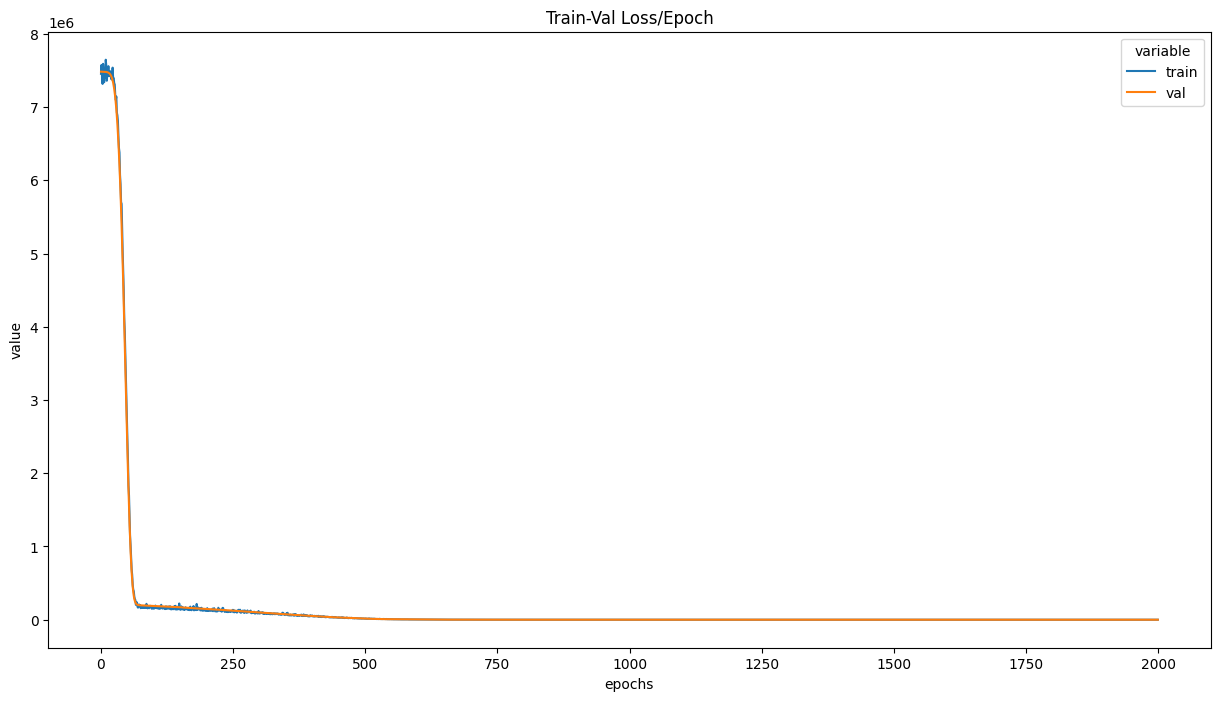

In [18]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

In [19]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())
y_pred_np = np.array(y_pred)
difference = np.subtract(y_pred_np, y_test)
print(difference)


100%|██████████| 2/2 [00:00<00:00, 20560.31it/s]

[2648.3298, 2639.4165, 2629.8267, 2619.932, 2608.821, 2597.7273, 2589.5503, 2579.322, 2564.8757, 2550.8147, 2540.1453, 2533.35, 2526.5464, 2523.3284, 2518.9543, 2511.2688, 2502.2014, 2490.1274, 2478.5757, 2467.9458, 2457.8796, 2446.795, 2436.3982, 2428.267, 2421.9214, 2415.483, 2405.8467, 2395.2668, 2381.3887, 2373.865, 2371.5264, 2376.695, 2382.3254, 2388.4429, 2395.6646, 2402.4878, 2408.4697, 2412.4155, 2418.3118, 2420.4849, 2422.7004, 2424.2468, 2429.0833, 2437.5247, 2444.65, 2450.8022, 2456.1206, 2465.0852, 2467.4875, 2470.4524, 2474.3213, 2481.6262, 2490.3464, 2499.9443, 2508.8838, 2517.4265, 2529.2012, 2545.217, 2560.8203, 2578.1233, 2594.463, 2605.3052, 2612.644, 2623.181, 2634.5508, 2644.809, 2655.8184, 2667.6748, 2678.2644, 2687.333, 2701.5933, 2720.9114, 2736.1262, 2753.73, 2773.3853, 2790.326, 2800.9553, 2814.3096, 2828.0393, 2836.779, 2837.9734, 2837.3381, 2833.0276, 2830.973, 2831.6594, 2831.4248, 2828.6868, 2832.125, 2833.1472, 2833.4429, 2839.6653, 2849.4822, 2870.3206, 

In [20]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")
print(f"Mean absolute percentage error: {100 - mean_abs_err}%")

Mean Squared Error : 10.319041462116179
R^2 : 0.999812916991563
Accuracy (using MSE): 89.68095853788382%
Mean absolute percentage error: 99.99910952369571%


#### Visualising the data

In [21]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [22]:
test_vals = temp.index[x_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()